# 2D Nuclear Segmentation with Multiple Semantic Heads

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/deepcell-tf')
!ls
!python setup.py build_ext --inplace
!pip install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
build		    deepcell	LICENSE     requirements-test.txt  setup.py
CODE_OF_CONDUCT.md  Dockerfile	pytest.ini  requirements.txt
CONTRIBUTING.md     docs	README.md   scripts
running build_ext
skipping 'deepcell/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/deepcell/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> deepcell/utils


In [0]:
import os
import errno

import numpy as np

import deepcell

In [0]:
# Download the data (saves to ~/.keras/datasets)
# filename = 'HeLa_S3.npz'
# test_size = 0.2 # % of data saved as test
# seed = 0 # seed for random train-test split

# (X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename, test_size=test_size, seed=seed)

# print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
filename = 'example.npz'
test_size = 0.05 # % of data saved as test
seed = 0 # seed for random train-test split
import numpy as np
from sklearn.model_selection import train_test_split
training_data = np.load('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example.npz')
X = training_data['X']
y = training_data['y']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
del X, y
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ny_test.shape: {}'.format(X_test.shape, y_test.shape))

X.shape: (95, 216, 256, 1)
y.shape: (95, 216, 256, 1)
X_test.shape: (5, 216, 256, 1)
y_test.shape: (5, 216, 256, 1)


### Set up filepath constants

In [0]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
# DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
DATA_DIR = '/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/'
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [0]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

# ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
ROOT_DIR = '/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/PanOpticFPN/' 
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

# Supported backbones:
# vgg16, vgg19
# densenet121, densenet169, densenet201
# mobilenet, mobilenetv2
# nasnet_large, nasnet_mobile
# resnet50
backbone = 'resnet50'

model_name = '{}_retinanet'.format(backbone)

n_epoch = 5  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1

num_classes = 1  # "object" is the only class

## Create the RetinaNet Model

In [0]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(y_train.astype('int'))

In [0]:
from deepcell import model_zoo

# training model is `retinanet` while prediction model is `retinanet_bbox`
model = model_zoo.RetinaMask(
    backbone=backbone,
    use_imagenet=False,
    panoptic=True,
    num_semantic_heads=2,
    num_semantic_classes=[4, 4],
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)
model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [0]:
from deepcell.training import train_model_retinanet


model = train_model_retinanet(
    model=model,
    backbone=backbone,
    dataset=DATA_FILE,  # full path to npz file
    model_name=model_name,
    include_masks=True,
    panoptic=True,
    panoptic_weight=0.1,
    transforms=['watershed', 'pixelwise'],
    transforms_kwargs={'pixelwise': {'separate_edge_classes': True}},
    anchor_params=anchor_params,
    pyramid_levels=pyramid_levels,
    sigma=3.0,
    alpha=0.5,
    gamma=2.0,
    weighted_average=True,
    score_threshold=0.01,
    iou_threshold=0.5,
    max_detections=100,
    test_size=test_size,
    seed=seed,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    compute_map=False,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (95, 216, 256, 1)
y_train shape: (95, 216, 256, 1)
X_test shape: (5, 216, 256, 1)
y_test shape: (5, 216, 256, 1)
Output Shape: (None, None, None, 4)
Number of Classes: 4
Training on 0 GPUs
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 3/57 [>.............................] - ETA: 4:48 - loss: 5.5087 - regression_loss: 3.0431 - classification_loss: 2.1995 - masks_loss: 0.0000e+00 - semantic_0_loss: 0.1379 - semantic_1_loss: 0.1282
Epoch 00001: val_loss improved from inf to 5.50866, saving model to /content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/PanOpticFPN/models/resnet50_retinanet.h5
15 instances of class 0 with average precision: 0.0000

mAP: 0.0000
57/57 [==============================] - 1025s 18s/step - loss: 5.0838 - regression_loss: 2.8064 - classification_loss: 1.9962 - masks_loss: 0.0610 - semantic_0_loss: 0.1083 - semantic_1_loss: 0.1120 - val_loss: 5.5087 - val_regression_loss: 3.0431 - val_classification_loss: 2.1995 - val_masks_loss: 0.0000e+00 - val_semantic_0_loss: 0.1379 - val_semantic_1_loss: 0.1282
Epoch 2/5
 3/57 [>.............................] - ETA: 4:03 - loss: 5.3497 - regression_loss: 3.0190 - classification_loss: 2.0736 - masks_loss: 0.0000e+00 - semantic_0_loss: 0.1319 - semanti

In [0]:
# Set up the prediction model
from deepcell import model_zoo

# Set up the prediction model
prediction_model = model_zoo.RetinaMask(
    backbone=backbone,
    use_imagenet=False,
    panoptic=True,
    num_semantic_heads=2,
    num_semantic_classes=[4, 4],
    input_shape=(None, None, X_train.shape[-1]),  # general input size
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

prediction_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [0]:
from skimage.transform import resize 
from skimage.measure import label
from skimage.morphology import watershed, remove_small_objects
from skimage.feature import peak_local_max
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import random_walker, relabel_sequential
from tensorflow.keras import backend as K


def compute_iou(a, b):
    """Computes the IoU overlap of boxes in a and b.
    Args:
        a: (N, H, W) ndarray of float
        b: (K, H, W) ndarray of float
    Returns
        overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    intersection = np.zeros((a.shape[0], b.shape[0]))
    union = np.zeros((a.shape[0], b.shape[0]))
    for index, mask in enumerate(a):
        intersection[index, :] = np.sum(np.count_nonzero(np.logical_and(b, mask), axis=1), axis=1)
        union[index, :] = np.sum(np.count_nonzero(b + mask, axis=1), axis=1)

    return intersection / union


def retinanet_to_label_image(retinanet_outputs, score_threshold=0.5, multi_iou_threshold=0.25,
                             binarize_threshold=0.5, watershed_threshold=0.5, small_objects_threshold=100):
    boxes_batch = retinanet_outputs[-5]
    scores_batch = retinanet_outputs[-4]
    labels_batch = retinanet_outputs[-3]
    masks_batch = retinanet_outputs[-2]
    semantic_batch = retinanet_outputs[-1]
    
    # Create empty label matrix
    label_images = np.zeros((masks_batch.shape[0], semantic_batch.shape[1], semantic_batch.shape[2]))
    
    # Iterate over batches
    for i in range(boxes_batch.shape[0]):
        boxes = boxes_batch[i]
        scores = scores_batch[i]
        labels = labels_batch[i]
        masks = masks_batch[i]
        semantic = semantic_batch[i]

        # Get good detections
        selection = np.nonzero(scores_batch[i] > score_threshold)[0]
        boxes = boxes[selection]
        scores = scores[selection]
        labels = labels[selection]
        masks = masks[selection, ..., -1]
        
        # Compute overlap of masks with each other
        mask_shape = (masks.shape[0], semantic.shape[0], semantic.shape[1])
        mask_image = np.zeros(mask_shape, dtype=K.floatx())

        for j in range(masks.shape[0]):
            mask = masks[j]
            box = boxes[j].astype(int)
            try:
                mask = resize(mask, (box[3] - box[1], box[2] - box[0]))
            except:
                print(box)
            mask = (mask > binarize_threshold).astype(K.floatx())
            mask_image[j, box[1]:box[3], box[0]:box[2]] = mask
        
        ious = compute_iou(mask_image, mask_image)
        
        # Identify all the masks with no overlaps and 
        # add to the label matrix
        summed_ious = np.sum(ious, axis=-1)
        no_overlaps = np.where(summed_ious == 1)
        
        masks_no_overlaps = mask_image[no_overlaps]
        range_no_overlaps = np.arange(1, masks_no_overlaps.shape[0] + 1)
        masks_no_overlaps *= np.expand_dims(np.expand_dims(range_no_overlaps, axis=-1), axis=-1)
        
        masks_concat = masks_no_overlaps
        
        # If a mask has a big iou with two other masks, remove it
        overlaps = np.where(summed_ious > 1)
        bad_mask = np.sum(ious > multi_iou_threshold, axis=0)
        good_overlaps = np.logical_and(summed_ious > 1, bad_mask < 3)
        good_overlaps = np.where(good_overlaps == 1)
        
        # Identify all the ambiguous pixels and resolve
        # by performing marker based watershed using unambiguous
        # pixels as the markers
        masks_overlaps = mask_image[good_overlaps]
        range_overlaps = np.arange(1, masks_overlaps.shape[0] + 1)
        masks_overlaps_label = masks_overlaps * np.expand_dims(
            np.expand_dims(range_overlaps, axis=-1), axis=-1)
        
        masks_overlaps_sum = np.sum(masks_overlaps, axis=0)
        ambiguous_pixels = np.where(masks_overlaps_sum > 1)
        markers = np.sum(masks_overlaps_label, axis=0)
        
        if np.sum(markers.flatten()) > 0:
            markers[markers == 0] = -1
            markers[ambiguous_pixels] = 0

            foreground = masks_overlaps_sum > 0
            segments = random_walker(foreground, markers)

            masks_overlaps = np.zeros((np.amax(segments).astype(int), 
                                       masks_overlaps.shape[1], masks_overlaps.shape[2]))

            for j in range(1, masks_overlaps.shape[0] + 1):
                masks_overlaps[j - 1] = segments == j

            range_overlaps = np.arange(masks_no_overlaps.shape[0] + 1, 
                                       masks_no_overlaps.shape[0] + masks_overlaps.shape[0] + 1)
            masks_overlaps *= np.expand_dims(np.expand_dims(range_overlaps, axis=-1), axis=-1)
            masks_concat = np.concatenate([masks_concat, masks_overlaps], axis=0)
              
            
        # Find peaks in watershed that are not within any
        # box and perform watershed
        semantic_argmax = np.argmax(semantic, axis=-1) 
        semantic_argmax *= np.sum(masks_concat, axis=0) < 1
        foreground = semantic_argmax > 0

        inner_most = semantic[..., -1] * (np.sum(masks_concat, axis=0) < 1)
        local_maxi = inner_most > watershed_threshold
        
        if np.sum(local_maxi.flatten()) > 0:
            markers_semantic = label(local_maxi)
            distance = semantic_argmax
            segments_semantic = watershed(-distance, markers_semantic, mask=foreground)
            masks_semantic = np.zeros((np.amax(segments_semantic).astype(int), 
                                       semantic.shape[0], semantic.shape[1]))
            for j in range(1, masks_semantic.shape[0] + 1):
                masks_semantic[j-1] = segments_semantic == j
            
            range_semantic = np.arange(masks_no_overlaps.shape[0] + masks_overlaps.shape[0] + 1,
                                       masks_no_overlaps.shape[0] + masks_overlaps.shape[0] + masks_semantic.shape[0] + 1)

            masks_semantic *= np.expand_dims(np.expand_dims(range_semantic, axis=-1), axis=-1)
        
            masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        
        label_image = np.sum(masks_concat, axis=0).astype(int)
        
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        
        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)
        
        # Store in batched array
        label_images[i] = label_image
        
    return label_images

Image Number: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


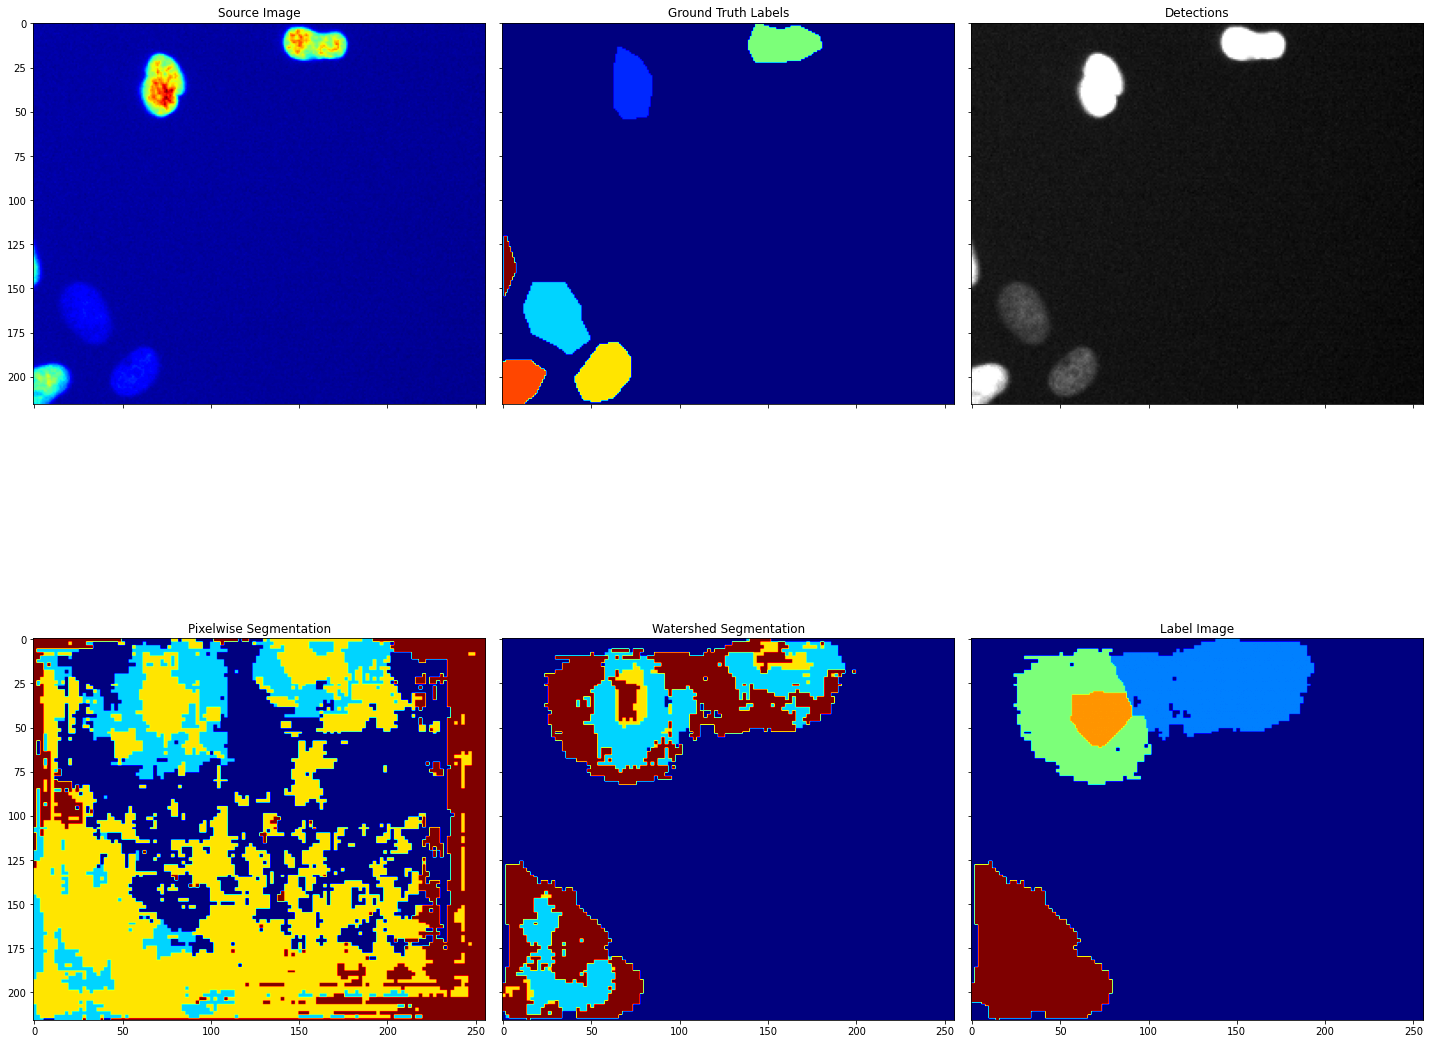

In [0]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from skimage.transform import resize 
from skimage.measure import label
from skimage.exposure import equalize_hist, rescale_intensity

from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

results = prediction_model.predict(image)

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

boxes  = results[-6]
scores = results[-5]
labels = results[-4]
masks  = results[-3]
semantic = [np.argmax(s[0], axis=-1) for s in results[-2:]]

label_image = retinanet_to_label_image(results[:-1])

# copy to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0], score_threshold=0.5)

display_image = image.copy()
display_image = rescale_intensity(display_image, out_range=(-1, 1))

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(display_image[..., -1], cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

ax[3].imshow(semantic[1], cmap='jet')
ax[3].set_title('Pixelwise Segmentation')
            
ax[4].imshow(semantic[0], cmap='jet')
ax[4].set_title('Watershed Segmentation')

ax[5].imshow(label_image[0], cmap='jet')
ax[5].set_title('Label Image')

plt.tight_layout()
plt.show()

In [0]:
display_image.shape

(216, 256, 3)

In [0]:
prediction_model.input

<tf.Tensor 'input_5:0' shape=(?, ?, ?, 1) dtype=float32>

In [0]:
prediction_model.output

[<tf.Tensor 'regression_1/concat:0' shape=(?, ?, 4) dtype=float32>,
 <tf.Tensor 'classification_1/concat:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'masks_1/concat:0' shape=(?, 100, ?) dtype=float32>,
 <tf.Tensor 'filtered_detections_1/map/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 100, 4) dtype=float32>,
 <tf.Tensor 'filtered_detections_1/map/TensorArrayStack_1/TensorArrayGatherV3:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'filtered_detections_1/map/TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?, 100) dtype=int32>,
 <tf.Tensor 'mask_submodel_1/roi_mask/Reshape_1:0' shape=(?, 100, 28, 28, 1) dtype=float32>,
 <tf.Tensor 'semantic_0_1/Softmax:0' shape=(?, ?, ?, 4) dtype=float32>,
 <tf.Tensor 'semantic_1_1/Softmax:0' shape=(?, ?, ?, 4) dtype=float32>]

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
#If the model has only one input it can be converted
OUTPUT_DIR = os.path.join(MODEL_DIR, 'mask_submodel_1') 

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  prediction_model.input},
            outputs = {'output': prediction_model.output[6]})
signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

# #If the model has only one input it can be converted
# OUTPUT_DIR = os.path.join(MODEL_DIR, 'saved_model_edgeseg') 

# builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

# signature = tf.saved_model.signature_def_utils.predict_signature_def(
#             inputs  = {'input':  run_watershed_model.input},
#             outputs = {'output': run_watershed_model.output})
# signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

# builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
#                                              signature_def_map=signature_def_map)
# builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/PanOpticFPN/models/mask_submodel_1/saved_model.pb


b'/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/PanOpticFPN/models/mask_submodel_1/saved_model.pb'